In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import sys
import seaborn as sns
import matplotlib.pyplot as plt

from data_pipeline.score import field_names
from data_pipeline.comparison_tool.src import utils   

pd.options.display.float_format = "{:,.3f}".format
%load_ext lab_black

# Comparator definition comparison

This notebook answers a few questions:
1. How many tracts are flagged and what's the size of overlap by comparator?
2. What are the demographics of each set of tracts by "category" of score (CEJST but not comparator, comparator but not CEJST, CEJST and comparator)?
3. What are the overall demographics of ALL comparator vs ALL CEJST?

It produces a single Excel file of the stats listed, but is interactive even after run-time. This notebook focuses on 1:1 comparison. It can be pointed in the YAML to either a simple output (tract and boolean for highlight) or to the output from an ETL.

In [2]:
## These are parameters and get overridden by the "injected parameters" cell below
ADDITIONAL_DEMO_COLUMNS = []
COMPARATOR_COLUMN = None
COMPARATOR_FILE = None
DEMOGRAPHIC_COLUMNS = []
DEMOGRAPHIC_FILE = None
OUTPUT_DATA_PATH = None
SCORE_FILE = None
OTHER_COMPARATOR_COLUMNS = None
OUTPUT_NAME = None
KEEP_MISSING_VALUES_FOR_SEGMENTATION = True

In [3]:
# Parameters
ADDITIONAL_DEMO_COLUMNS = [
    "Urban Heuristic Flag",
    "Percent of individuals below 200% Federal Poverty Line",
    "Percent individuals age 25 or over with less than high school degree",
    "Unemployment (percent)",
    "Percent of households in linguistic isolation",
]
COMPARATOR_COLUMN = "nys_dac"
COMPARATOR_FILE = "/Users/emmausds/Desktop/justice40-tool/data/data-pipeline/data_pipeline/comparison_tool/data/nyc_dacs/clean/nys_dac.csv"
DEMOGRAPHIC_COLUMNS = [
    "Percent Black or African American alone",
    "Percent American Indian and Alaska Native alone",
    "Percent Asian alone",
    "Percent Native Hawaiian and Other Pacific alone",
    "Percent Two or more races",
    "Percent Non-Hispanic White",
    "Percent Hispanic or Latino",
]
DEMOGRAPHIC_FILE = "/Users/emmausds/Desktop/justice40-tool/data/data-pipeline/data_pipeline/data/dataset/census_acs_2019/usa.csv"
OUTPUT_DATA_PATH = "/Users/emmausds/Desktop/justice40-tool/data/data-pipeline/data_pipeline/comparison_tool/output/nys_dacs"
SCORE_FILE = "/Users/emmausds/Desktop/justice40-tool/data/data-pipeline/data_pipeline/data/score/csv/full/usa.csv"
OTHER_COMPARATOR_COLUMNS = [
    "Tribal_Designation",
    "Household_Low_Count_Flag",
    "Population_Count",
    "Household_Count",
    "Percentile_Rank_Combined_Statewide",
    "Percentile_Rank_Combined_NYC",
    "Percentile_Rank_Combined_ROS",
    "Combined_Score",
    "Burden_Score_Percentile",
    "Vulnerability_Score_Percentile",
    "Burden_Score",
    "Vulnerability_Score",
    "Benzene_Concentration",
    "Particulate_Matter_25",
    "Traffic_Truck_Highways",
    "Traffic_Number_Vehicles",
    "Wastewater_Discharge",
    "Housing_Vacancy_Rate",
    "Industrial_Land_Use",
    "Landfills",
    "Oil_Storage",
    "Municipal_Waste_Combustors",
    "Power_Generation_Facilities",
    "RMP_Sites",
    "Remediation_Sites",
    "Scrap_Metal_Processing",
    "Agricultural_Land_Use",
    "Coastal_Flooding_Storm_Risk",
    "Days_Above_90_Degrees_2050",
    "Drive_Time_Healthcare",
    "Inland_Flooding_Risk",
    "Low_Vegetative_Cover",
    "Asian_Percent",
    "Black_African_American_Percent",
    "Redlining_Updated",
    "Latino_Percent",
    "English_Proficiency",
    "Native_Indigenous",
    "LMI_80_AMI",
    "LMI_Poverty_Federal",
    "Population_No_College",
    "Household_Single_Parent",
    "Unemployment_Rate",
    "Asthma_ED_Rate",
    "COPD_ED_Rate",
    "Households_Disabled",
    "Low_Birth_Weight",
    "MI_Hospitalization_Rate",
    "Health_Insurance_Rate",
    "Age_Over_65",
    "Premature_Deaths",
    "Internet_Access",
    "Home_Energy_Affordability",
    "Homes_Built_Before_1960",
    "Mobile_Homes",
    "Rent_Percent_Income",
    "Renter_Percent",
]
KEEP_MISSING_VALUES_FOR_SEGMENTATION = True
OUTPUT_NAME = "nys_dacs"


In [4]:
## These are constants for all runs
GEOID_COLUMN = field_names.GEOID_TRACT_FIELD
SCORE_COLUMN = field_names.SCORE_M_COMMUNITIES
TOTAL_POPULATION_COLUMN = field_names.TOTAL_POP_FIELD

__Date and time of last run__

In [5]:
datetime.datetime.now()

datetime.datetime(2022, 3, 30, 17, 30, 40, 360792)

__Congfigure output (autocreated)__

In [6]:
OUTPUT_EXCEL = os.path.join(
    OUTPUT_DATA_PATH,
    f"{OUTPUT_NAME}__{datetime.datetime.now().strftime('%Y-%m-%d')}.xlsx",
)

__Validate new data__

In [7]:
utils.validate_new_data(
    file_path=COMPARATOR_FILE, score_col=COMPARATOR_COLUMN
)

__Read in data__

In [8]:
comparator_cols = [COMPARATOR_COLUMN] + OTHER_COMPARATOR_COLUMNS if OTHER_COMPARATOR_COLUMNS else [COMPARATOR_COLUMN]

#papermill_description=Loading_data
joined_df = pd.concat(
    [
        utils.read_file(
            file_path=SCORE_FILE,
            columns=[TOTAL_POPULATION_COLUMN, SCORE_COLUMN] + ADDITIONAL_DEMO_COLUMNS,
            geoid=GEOID_COLUMN,
        ),
        utils.read_file(
            file_path=COMPARATOR_FILE,
            columns=comparator_cols,
            geoid=GEOID_COLUMN
        ),
        utils.read_file(
            file_path=DEMOGRAPHIC_FILE,
            columns=DEMOGRAPHIC_COLUMNS,
            geoid=GEOID_COLUMN,
        ),
    ],
    axis=1,
).reset_index()

## High-level summary

What *shares* of tracts and population highlighted by the comparator are covered by CEJST?

In [9]:
#papermill_description=Summary_stats
population_df = utils.produce_summary_stats(
    joined_df=joined_df,
    comparator_column=COMPARATOR_COLUMN,
    score_column=SCORE_COLUMN,
    population_column=TOTAL_POPULATION_COLUMN,
    geoid_column=GEOID_COLUMN
)
population_df

Population  Count of tracts  \
nys_dac Definition M (communities)                                    
False   False                       10,770,979.000             2678   
        True                         1,864,100.000              519   
True    False                        2,579,235.000              642   
        True                         4,404,139.000             1079   
missing False                      219,440,748.000            47363   
        True                        87,230,770.000            21879   

                                    Share of tracts  Share of population  
nys_dac Definition M (communities)                                        
False   False                                 0.036                0.033  
        True                                  0.007                0.006  
True    False                                 0.009                0.008  
        True                                  0.015                0.013  
missing False                                 0.639                0.673  
        True                                  0.295                0.267

## Tract-level stats

First, this walks through overall stats for disadvantaged communities under the comparator definition and under the CEJST's definition. Next, this walks through stats by group (e.g., CEJST and not comparator). This is at the tract level, so the average across tracts, where tracts are not population-weighted. 

In [10]:
#papermill_description=Tract_stats
tract_level_by_identification_df = pd.concat(
    [
        utils.get_demo_series(
            grouping_column=COMPARATOR_COLUMN,
            joined_df=joined_df,
            demo_columns=ADDITIONAL_DEMO_COLUMNS + DEMOGRAPHIC_COLUMNS
        ),
        utils.get_demo_series(
            grouping_column=SCORE_COLUMN,
            joined_df=joined_df,
            demo_columns=ADDITIONAL_DEMO_COLUMNS + DEMOGRAPHIC_COLUMNS
        ),
    ],
    axis=1,
)

tract_level_by_identification_df

,nys_dac,Definition M (communities)
Urban Heuristic Flag,0.954,0.839
Percent of individuals below 200% Federal Poverty Line,0.442,0.530
Percent individuals age 25 or over with less than high school degree,0.208,0.225
Unemployment (percent),0.079,0.091
Percent of households in linguistic isolation,0.124,0.112
Percent Black or African American alone,0.265,0.250
Percent American Indian and Alaska Native alone,0.009,0.016
Percent Asian alone,0.075,0.040
Percent Native Hawaiian and Other Pacific alone,0.001,0.002
Percent Two or more races,0.042,0.034


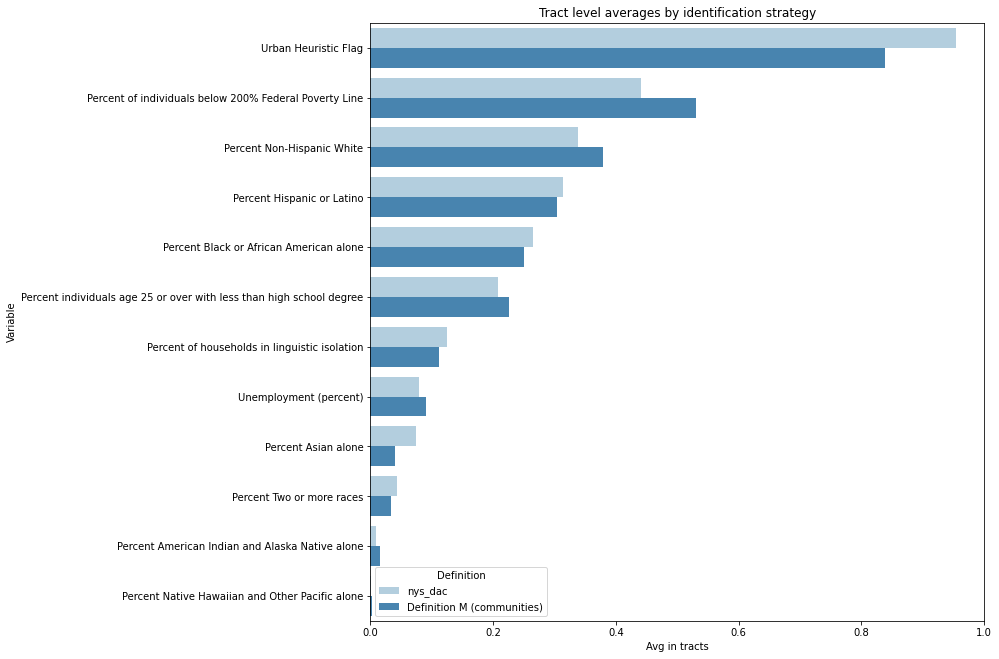

In [11]:
plt.figure(figsize=(11, 11))
sns.barplot(
    y="Variable",
    x="Avg in tracts",
    hue="Definition",
    data=tract_level_by_identification_df.sort_values(by=COMPARATOR_COLUMN, ascending=False)
    .stack()
    .reset_index()
    .rename(
        columns={"level_0": "Variable", "level_1": "Definition", 0: "Avg in tracts"}
    ),
    palette="Blues",
)
plt.xlim(0, 1)
plt.title("Tract level averages by identification strategy")
plt.savefig(os.path.join(OUTPUT_DATA_PATH, "tract_lvl_avg.jpg"), bbox_inches='tight')

In [12]:
#papermill_description=Tract_stats_grouped
tract_level_by_grouping_df = utils.get_tract_level_grouping(
    joined_df=joined_df,
    score_column=SCORE_COLUMN,
    comparator_column=COMPARATOR_COLUMN,
    demo_columns=ADDITIONAL_DEMO_COLUMNS + DEMOGRAPHIC_COLUMNS,
    keep_missing_values=KEEP_MISSING_VALUES_FOR_SEGMENTATION
)

tract_level_by_grouping_formatted_df = utils.format_multi_index_for_excel(
    df=tract_level_by_grouping_df
)

In [13]:
tract_level_by_grouping_formatted_df

,Variable,"Not CEJST, Not Comparator","Not CEJST, Comparator","Not CEJST, No Comparator classification","CEJST, Not Comparator","CEJST, Comparator","CEJST, No Comparator classification"
0,Urban Heuristic Flag,0.816,0.901,0.788,0.956,0.985,0.828
1,Percent of individuals below 200% Federal Pove...,0.194,0.285,0.240,0.415,0.534,0.533
2,Percent individuals age 25 or over with less t...,0.076,0.131,0.082,0.206,0.254,0.225
3,Unemployment (percent),0.043,0.055,0.045,0.062,0.094,0.092
4,Percent of households in linguistic isolation,0.032,0.052,0.026,0.201,0.167,0.107
5,Percent Black or African American alone,0.107,0.199,0.083,0.145,0.305,0.249
6,Percent American Indian and Alaska Native alone,0.002,0.006,0.006,0.003,0.011,0.017
7,Percent Asian alone,0.064,0.065,0.053,0.226,0.080,0.034
8,Percent Native Hawaiian and Other Pacific alone,0.000,0.001,0.002,0.000,0.001,0.002
9,Percent Two or more races,0.024,0.039,0.032,0.030,0.044,0.034


## Population-weighted stats

In [14]:
#papermill_description=Population_stats
population_weighted_stats_df = pd.concat(
    [
        utils.construct_weighted_statistics(
            input_df=joined_df,
            weighting_column=COMPARATOR_COLUMN,
            demographic_columns=DEMOGRAPHIC_COLUMNS + ADDITIONAL_DEMO_COLUMNS,
            population_column=TOTAL_POPULATION_COLUMN,
        ),
        utils.construct_weighted_statistics(
            input_df=joined_df,
            weighting_column=SCORE_COLUMN,
            demographic_columns=DEMOGRAPHIC_COLUMNS + ADDITIONAL_DEMO_COLUMNS,
            population_column=TOTAL_POPULATION_COLUMN,
        ),
    ],
    axis=1,
)

In [15]:
population_weighted_stats_df

,not nys_dac,nys_dac,not Definition M (communities),Definition M (communities)
Percent Black or African American alone,0.097,0.264,0.089,0.223
Percent American Indian and Alaska Native alone,0.002,0.007,0.006,0.015
Percent Asian alone,0.090,0.075,0.059,0.044
Percent Native Hawaiian and Other Pacific alone,0.000,0.001,0.002,0.002
Percent Two or more races,0.025,0.043,0.033,0.034
Percent Non-Hispanic White,0.686,0.320,0.696,0.362
Percent Hispanic or Latino,0.108,0.339,0.126,0.345
Urban Heuristic Flag,0.847,0.955,0.819,0.823
Percent of individuals below 200% Federal Poverty Line,0.222,0.437,0.233,0.520
Percent individuals age 25 or over with less than high school degree,0.093,0.213,0.082,0.232


## Final information about overlap

In [16]:
comparator_and_cejst_proportion_series, states = utils.get_final_summary_info(
    population=population_df,
    comparator_file=COMPARATOR_FILE,
    geoid_col=GEOID_COLUMN
)

In [17]:
states_text = "States included in comparator: " + states
states_text

'States included in comparator: NY'

## Print to excel

In [18]:
#papermill_description=Writing_excel
utils.write_single_comparison_excel(
    output_excel=OUTPUT_EXCEL,
    population_df=population_df,
    tract_level_by_identification_df=tract_level_by_identification_df,
    population_weighted_stats_df=population_weighted_stats_df,
    tract_level_by_grouping_formatted_df=tract_level_by_grouping_formatted_df,
    comparator_and_cejst_proportion_series=comparator_and_cejst_proportion_series,
    states_text=states_text
)